# Training while monitoring observables

As seen in the first tutorial that went through reconstructing the wavefunction describing the TFIM with 10 sites at its critical point, the user can evaluate the training in real time with the `MetricEvaluator` and custom functions. What is most likely more impactful in many cases is to calculate an observable, like the energy, during the training process. This is slightly more computationally involved than using the `MetricEvaluator` to evaluate functions because observables require that samples be drawn from the RBM. 

Luckily, QuCumber also has a module very similar to the `MetricEvaluator`, but for observables. This is called the `ObservableEvaluator`. This tutorial uses the `ObservableEvaluator` to calculate the energy during the training on the TFIM data in the first tutorial. We will use the same training hyperparameters as before.

It is assumed that the user has worked through Tutorial 3 beforehand. Recall that `quantum_ising_chain.py` contains the `TFIMChainEnergy` class that inherits from the `Observable` module. The exact ground-state energy is $-1.2381$.

In [1]:
import os.path

import numpy as np
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWaveFunction
from qucumber.callbacks import ObservableEvaluator

import qucumber.utils.data as data

from quantum_ising_chain import TFIMChainEnergy

In [2]:
train_data = data.load_data(
    os.path.join("..", "Tutorial1_TrainPosRealWaveFunction", "tfim1d_data.txt")
)[0]

nv = train_data.shape[-1]
nh = nv

nn_state = PositiveWaveFunction(num_visible=nv, num_hidden=nh)

epochs = 1000
pbs = 100  # pos_batch_size
nbs = 200  # neg_batch_size
lr = 0.01
k = 10

period = 100

h = 1
num_samples = 10000
burn_in = 100
steps = 100

tfim_energy = TFIMChainEnergy(h)

Now, the `ObservableEvaluator` can be called. The `ObservableEvaluator` requires the following arguments.

1. `period`: the frequency of the training evaluators being calculated (e.g. `period=200` means that the `MetricEvaluator` will compute the desired metrics every 200 epochs)
2. A list of `Observable` objects you would like to reference to evaluate the training (arguments required for generating samples to calculate the observables are keyword arguments placed after the list). The `ObservableEvaluator` uses a `System` object (discussed in the previous tutorial) under the hood in order to estimate statistics efficiently.

The following additional arguments are needed to calculate the statistics on the generated samples during training (these are the arguments of the `statistics` function in the `Observable` module, minus the `nn_state` argument; this gets passed in as an argument to `fit`). For more detail on these arguments, refer to either the previous tutorial or the documentation for `Observable.statistics`.

- `num_samples`: the number of samples to generate internally
- `num_chains`: the number of Markov chains to run in parallel (default = 0)
- `burn_in`: the number of Gibbs steps to perform before recording any samples (default = 1000)
- `steps`: the number of Gibbs steps to perform between each sample (default = 1)

The training evaluators can be printed out by setting the `verbose` keyword argument to `True`.

In [3]:
callbacks = [
    ObservableEvaluator(
        period,
        [tfim_energy],
        verbose=True,
        num_samples=num_samples,
        burn_in=burn_in,
        steps=steps,
    )
]

nn_state.fit(
    train_data,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    callbacks=callbacks,
)

Epoch: 100
  TFIMChainEnergy:
    mean: -1.193770	variance: 0.024622	std_error: 0.001569
Epoch: 200
  TFIMChainEnergy:
    mean: -1.215802	variance: 0.013568	std_error: 0.001165
Epoch: 300
  TFIMChainEnergy:
    mean: -1.221930	variance: 0.009081	std_error: 0.000953
Epoch: 400
  TFIMChainEnergy:
    mean: -1.227180	variance: 0.006347	std_error: 0.000797
Epoch: 500
  TFIMChainEnergy:
    mean: -1.230074	variance: 0.004502	std_error: 0.000671
Epoch: 600
  TFIMChainEnergy:
    mean: -1.232001	variance: 0.003641	std_error: 0.000603
Epoch: 700
  TFIMChainEnergy:
    mean: -1.233434	variance: 0.002839	std_error: 0.000533
Epoch: 800
  TFIMChainEnergy:
    mean: -1.235324	variance: 0.002306	std_error: 0.000480
Epoch: 900
  TFIMChainEnergy:
    mean: -1.235313	variance: 0.001936	std_error: 0.000440
Epoch: 1000
  TFIMChainEnergy:
    mean: -1.235257	variance: 0.001590	std_error: 0.000399


The `callbacks` list returns a list of dictionaries. The mean, standard error and the variance at each epoch can be accessed as follows:

In [4]:
# Note that the name of the observable class that the user makes
# must be what comes after callbacks[0].
energies = callbacks[0].TFIMChainEnergy.mean

# Alternatively, we can use the usual dictionary/list subscripting
# syntax, which is useful in the case where the observable's name
# contains special characters
errors = callbacks[0]["TFIMChainEnergy"].std_error
variance = callbacks[0]["TFIMChainEnergy"]["variance"]

A plot of the energy as a function of the training cycle is presented below.

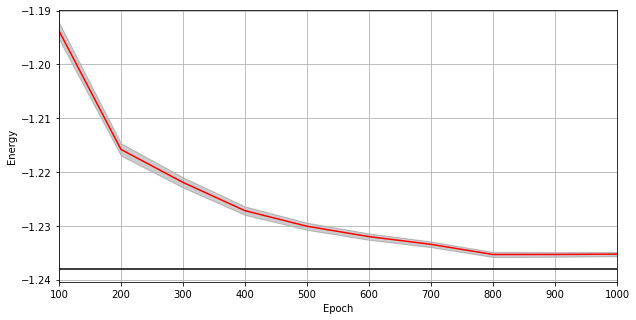

In [5]:
epoch = np.arange(period, epochs + 1, period)

E0 = -1.2381

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.plot(epoch, energies, color="red")
ax.set_xlim(period, epochs)
ax.axhline(E0, color="black")
ax.fill_between(epoch, energies - errors, energies + errors, alpha=0.2, color="black")
ax.set_xlabel("Epoch")
ax.set_ylabel("Energy")
ax.grid()